In [251]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib
import protos_pb2
import protos_pb2_grpc
import grpc

In [267]:
channel = grpc.insecure_channel('127.0.0.1:8080')
stub = protos_pb2_grpc.DataServiceStub(channel)

request = protos_pb2.GetPriceHistoryRequest()
request.symbol.name = protos_pb2.Symbol.EUR_USD
request.symbol.broker = protos_pb2.Broker.XTB_DEMO
request.window_nanoseconds = 300000000000 # 5 minutes

result = stub.GetPriceHistory(request)

In [268]:
data = []

for candlestick in result.candlesticks:
    ts = candlestick.timestamp.ToJsonString()
    data.append({
        "time": pd.to_datetime(ts),
        "low":   float(candlestick.low)  / 1000000,
        "high":  float(candlestick.high) / 1000000,
        "open":  float(candlestick.open) / 1000000,
        "close": float(candlestick.close) / 1000000,
    })

df = pd.DataFrame(data)
indexed = df.set_index('time')

df.head()

,time,low,high,open,close
0,2020-03-05 20:55:00+00:00,1.12261,1.12290,1.12268,1.12283
1,2020-03-05 21:00:00+00:00,1.12266,1.12303,1.12282,1.12284
2,2020-03-05 23:05:00+00:00,1.12285,1.12301,1.12301,1.12286
3,2020-03-05 23:10:00+00:00,1.12281,1.12290,1.12285,1.12283
4,2020-03-05 23:15:00+00:00,1.12262,1.12289,1.12282,1.12282


In [269]:
fig = go.Figure(data=[go.Candlestick(x=df['time'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
fig.show()

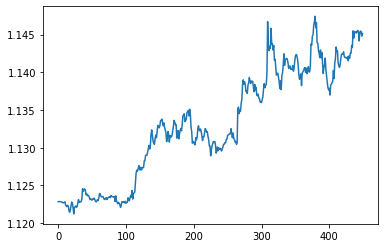

In [270]:
close = indexed['close']
df['close'].plot()

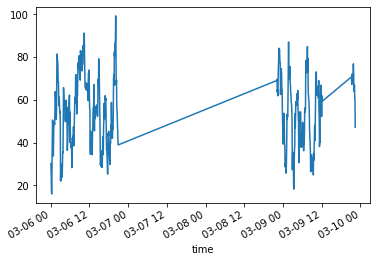

In [271]:
windowPeriods = 14

delta = close.diff()
# Get rid of the first row, which is NaN since it did not have a previous 
# row to calculate the differences
delta = delta[1:] 

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

# Calculate the EWMA
roll_up1 = up.ewm(span=windowPeriods).mean()
roll_down1 = down.abs().ewm(span=windowPeriods).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

# Calculate the SMA
roll_up2 = up.rolling(windowPeriods).mean()
roll_down2 = down.abs().rolling(windowPeriods).mean()

# Calculate the RSI based on SMA
RS2 = roll_up2 / roll_down2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))

#RSI1.plot()
RSI2.plot()